In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import pandas as pd

coor_data = pd.read_csv('Data/coordata.csv')
date_data = pd.read_csv('Data/datedata.csv')
meta_data = pd.read_csv('Data/metadata.csv')

I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\tensorflow\python\framework

In [54]:
data_set = coor_data.join(date_data.join(meta_data))

Y_data = data_set[['endx', 'endy']].to_numpy()
X_data = data_set.drop(columns=['endx', 'endy','end_grid_x', 'end_grid_y','start_grid_x', 'start_grid_y','start_date', 'class','end_cluster_group']).to_numpy()

In [55]:


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

sc = MinMaxScaler(feature_range=(0,1))
X_data_n = sc.fit_transform(X_data)
Y_data_n = sc.fit_transform(Y_data)

x_train, x_test, y_train, y_test = train_test_split(X_data_n, Y_data_n, test_size=0.3, shuffle=False)

In [39]:
from tensorflow.keras import layers, Model
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
inputA = layers.Input(shape=(4))
inputB = layers.Input(shape=(58))

# x = Dense(50, activation="relu")(inputA)
x = Dense(50, activation="relu")(inputA)
x = Model(inputs=inputA, outputs=x)
y = Dense(50, activation="relu")(inputB)
y = Model(inputs=inputB, outputs=y)

combined = layers.concatenate([x.output, y.output])

z = Dense(2)(combined)

model = Model(inputs=[x.input,y.input], outputs=z)
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 58)]         0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 50)           250         input_11[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 50)           2950        input_12[0][0]                   
___________________________________________________________________________________________

In [40]:

from tensorflow.python.keras.callbacks import EarlyStopping

def error_avg_km(y_true, y_pred):
    absolute = abs(y_true - y_pred)
    return tf.reduce_mean(absolute*111, axis=-1)
model.compile(loss="mean_absolute_error", optimizer="adam", metrics=[error_avg_km,'acc'])

callback = EarlyStopping(monitor='error_avg_km', patience=3, mode="auto")
model.fit([x_train[:,0:4],x_train[:,4:]], y_train, epochs=100, validation_data=([x_test[:,0:4],x_test[:,4:]], y_test), callbacks=[callback])

Train on 321634 samples, validate on 137844 samples
Epoch 1/100
321634/321634 [==============================] - 12s 37us/sample - loss: 0.0214 - error_avg_km: 2.3772 - acc: 0.7452 - val_loss: 0.0201 - val_error_avg_km: 2.2265 - val_acc: 0.7301
Epoch 2/100
321634/321634 [==============================] - 12s 37us/sample - loss: 0.0192 - error_avg_km: 2.1352 - acc: 0.7576 - val_loss: 0.0193 - val_error_avg_km: 2.1392 - val_acc: 0.7316
Epoch 3/100
321634/321634 [==============================] - 11s 35us/sample - loss: 0.0191 - error_avg_km: 2.1167 - acc: 0.7590 - val_loss: 0.0194 - val_error_avg_km: 2.1515 - val_acc: 0.7294
Epoch 4/100
321634/321634 [==============================] - 12s 36us/sample - loss: 0.0190 - error_avg_km: 2.1054 - acc: 0.7595 - val_loss: 0.0195 - val_error_avg_km: 2.1651 - val_acc: 0.7257
Epoch 5/100
321634/321634 [==============================] - 12s 37us/sample - loss: 0.0189 - error_avg_km: 2.1030 - acc: 0.7599 - val_loss: 0.0195 - val_error_avg_km: 2.1658 -

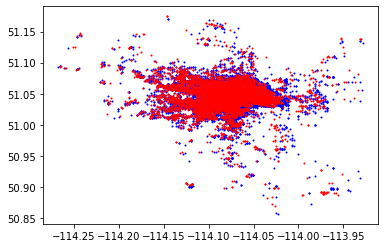

In [43]:
import matplotlib.pyplot as plt
import numpy as np
sc.fit_transform(Y_data)
result_Y = model.predict([x_test[:,0:4],x_test[:,4:]])


result_Y_plot = sc.inverse_transform(result_Y)
y_test_plot = sc.inverse_transform(y_test)
plt.scatter((y_test_plot[:,0]),(y_test_plot[:,1]), color='b', s= 1)
plt.scatter((result_Y_plot[:,0]), (result_Y_plot[:,1]), color='r', s= 1)



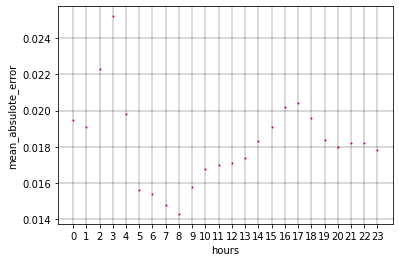

In [44]:
mae_rate_hour = []

sc.fit_transform(X_data)
for index in range(24):
    mask = np.logical_and(sc.inverse_transform(x_test)[:,2] > (index)-0.1, sc.inverse_transform(x_test)[:,2] < (index+1)-0.5)
    result_Y_hour = result_Y[mask]
    Y_test_in = y_test[mask]
    error = abs(result_Y_hour - Y_test_in)
    endx = sum(error[:,0])/len(error)
    endy = sum(error[:,1])/len(error)
    error_average_distance = (endx+endy)/2

    y_test[:,0] = y_test[:,0]
    mae_rate_hour.append([float(round(error_average_distance,4)), str(index)])

mae_rate_hour = np.array(mae_rate_hour, dtype=np.object)
plt.xlabel('hours')
plt.ylabel('mean_absulote_error')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter(mae_rate_hour[:,1], mae_rate_hour[:,0], color='r', s= 1)


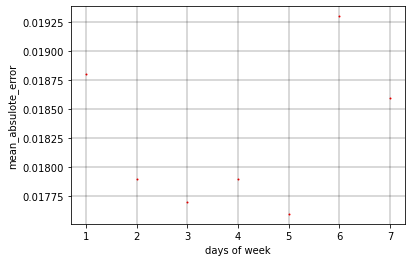

In [45]:
mae_rate_day_of_week = []

sc.fit_transform(X_data)
for index in range(7):
    mask = np.logical_and(sc.inverse_transform(x_test)[:,3] > (index)-0.1, sc.inverse_transform(x_test)[:,3] < (index+1)-0.5)
    result_Y_day_of_week = result_Y[mask]
    Y_test_in = y_test
    error = abs(result_Y_day_of_week - Y_test_in[mask])
    endx = sum(error[:,0])/len(error)
    endy = sum(error[:,1])/len(error)
    error_average_distance = (endx+endy)/2

    y_test[:,0] = y_test[:,0]
    mae_rate_day_of_week.append([float(round(error_average_distance,4)), str(index+1)])

mae_rate_day_of_week = np.array(mae_rate_day_of_week, dtype=np.object)
plt.xlabel('days of week')
plt.ylabel('mean_absulote_error')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter(mae_rate_day_of_week[:,1], mae_rate_day_of_week[:,0], color='r', s= 1)